# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [48]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('X_val: ', (1000, 3, 32, 32))
('y_train: ', (49000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))
('y_val: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [50]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769848888397517e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [51]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  1.0908199508708189e-10
dw error:  2.1752635504596857e-10
db error:  7.736978834487815e-12


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [52]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [53]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [54]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.395535042049294e-11
dw error:  8.162015570444288e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [55]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.384673161989355e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [56]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.37e-10
b1 relative error: 8.01e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.35e-08
b2 relative error: 1.97e-09


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [17]:
model = TwoLayerNet(hidden_dim=256, reg=0.02)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################

kwargs = {"update_rule": "sgd",
          "optim_config": {"learning_rate":6e-5},
          "lr_decay": 0.985,
          "batch_size": 256,
          "num_epochs": 100}

mysolver = Solver(model, data, **kwargs)
mysolver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 19100) loss: 2.314551
(Epoch 0 / 100) train acc: 0.095000; val_acc: 0.097000
(Iteration 11 / 19100) loss: 2.304535
(Iteration 21 / 19100) loss: 2.297553
(Iteration 31 / 19100) loss: 2.293997
(Iteration 41 / 19100) loss: 2.274690
(Iteration 51 / 19100) loss: 2.269803
(Iteration 61 / 19100) loss: 2.258268
(Iteration 71 / 19100) loss: 2.261205
(Iteration 81 / 19100) loss: 2.248053
(Iteration 91 / 19100) loss: 2.254511
(Iteration 101 / 19100) loss: 2.226147
(Iteration 111 / 19100) loss: 2.228657
(Iteration 121 / 19100) loss: 2.222335
(Iteration 131 / 19100) loss: 2.210582
(Iteration 141 / 19100) loss: 2.214833
(Iteration 151 / 19100) loss: 2.210010
(Iteration 161 / 19100) loss: 2.185900
(Iteration 171 / 19100) loss: 2.176026
(Iteration 181 / 19100) loss: 2.156202
(Iteration 191 / 19100) loss: 2.167855
(Epoch 1 / 100) train acc: 0.267000; val_acc: 0.278000
(Iteration 201 / 19100) loss: 2.132639
(Iteration 211 / 19100) loss: 2.140076
(Iteration 221 / 19100) loss: 2.131673
(Ite

(Iteration 1931 / 19100) loss: 1.607664
(Iteration 1941 / 19100) loss: 1.697136
(Iteration 1951 / 19100) loss: 1.689974
(Iteration 1961 / 19100) loss: 1.712868
(Iteration 1971 / 19100) loss: 1.740485
(Iteration 1981 / 19100) loss: 1.763300
(Iteration 1991 / 19100) loss: 1.692721
(Iteration 2001 / 19100) loss: 1.673220
(Iteration 2011 / 19100) loss: 1.644548
(Iteration 2021 / 19100) loss: 1.765661
(Iteration 2031 / 19100) loss: 1.641985
(Iteration 2041 / 19100) loss: 1.755131
(Iteration 2051 / 19100) loss: 1.657489
(Iteration 2061 / 19100) loss: 1.721248
(Iteration 2071 / 19100) loss: 1.755472
(Iteration 2081 / 19100) loss: 1.731243
(Iteration 2091 / 19100) loss: 1.652069
(Iteration 2101 / 19100) loss: 1.607999
(Epoch 11 / 100) train acc: 0.409000; val_acc: 0.411000
(Iteration 2111 / 19100) loss: 1.675141
(Iteration 2121 / 19100) loss: 1.732260
(Iteration 2131 / 19100) loss: 1.709749
(Iteration 2141 / 19100) loss: 1.666049
(Iteration 2151 / 19100) loss: 1.744742
(Iteration 2161 / 19100)

(Iteration 3841 / 19100) loss: 1.490179
(Iteration 3851 / 19100) loss: 1.596090
(Iteration 3861 / 19100) loss: 1.606520
(Iteration 3871 / 19100) loss: 1.507851
(Iteration 3881 / 19100) loss: 1.623173
(Iteration 3891 / 19100) loss: 1.643535
(Iteration 3901 / 19100) loss: 1.621144
(Iteration 3911 / 19100) loss: 1.563659
(Iteration 3921 / 19100) loss: 1.590374
(Iteration 3931 / 19100) loss: 1.542522
(Iteration 3941 / 19100) loss: 1.518641
(Iteration 3951 / 19100) loss: 1.554465
(Iteration 3961 / 19100) loss: 1.597316
(Iteration 3971 / 19100) loss: 1.517342
(Iteration 3981 / 19100) loss: 1.662239
(Iteration 3991 / 19100) loss: 1.584453
(Iteration 4001 / 19100) loss: 1.586974
(Iteration 4011 / 19100) loss: 1.581736
(Epoch 21 / 100) train acc: 0.429000; val_acc: 0.450000
(Iteration 4021 / 19100) loss: 1.602757
(Iteration 4031 / 19100) loss: 1.518064
(Iteration 4041 / 19100) loss: 1.616291
(Iteration 4051 / 19100) loss: 1.515535
(Iteration 4061 / 19100) loss: 1.612941
(Iteration 4071 / 19100)

(Iteration 5751 / 19100) loss: 1.572653
(Iteration 5761 / 19100) loss: 1.488189
(Iteration 5771 / 19100) loss: 1.475998
(Iteration 5781 / 19100) loss: 1.441625
(Iteration 5791 / 19100) loss: 1.499076
(Iteration 5801 / 19100) loss: 1.550401
(Iteration 5811 / 19100) loss: 1.507148
(Iteration 5821 / 19100) loss: 1.362327
(Iteration 5831 / 19100) loss: 1.623270
(Iteration 5841 / 19100) loss: 1.475366
(Iteration 5851 / 19100) loss: 1.549437
(Iteration 5861 / 19100) loss: 1.537316
(Iteration 5871 / 19100) loss: 1.505331
(Iteration 5881 / 19100) loss: 1.555785
(Iteration 5891 / 19100) loss: 1.631010
(Iteration 5901 / 19100) loss: 1.511720
(Iteration 5911 / 19100) loss: 1.507380
(Iteration 5921 / 19100) loss: 1.515026
(Epoch 31 / 100) train acc: 0.503000; val_acc: 0.468000
(Iteration 5931 / 19100) loss: 1.442348
(Iteration 5941 / 19100) loss: 1.474304
(Iteration 5951 / 19100) loss: 1.482131
(Iteration 5961 / 19100) loss: 1.586166
(Iteration 5971 / 19100) loss: 1.590343
(Iteration 5981 / 19100)

(Iteration 7661 / 19100) loss: 1.374308
(Iteration 7671 / 19100) loss: 1.496455
(Iteration 7681 / 19100) loss: 1.544637
(Iteration 7691 / 19100) loss: 1.446549
(Iteration 7701 / 19100) loss: 1.543153
(Iteration 7711 / 19100) loss: 1.478519
(Iteration 7721 / 19100) loss: 1.564303
(Iteration 7731 / 19100) loss: 1.465594
(Iteration 7741 / 19100) loss: 1.499267
(Iteration 7751 / 19100) loss: 1.448115
(Iteration 7761 / 19100) loss: 1.396869
(Iteration 7771 / 19100) loss: 1.553127
(Iteration 7781 / 19100) loss: 1.477361
(Iteration 7791 / 19100) loss: 1.469221
(Iteration 7801 / 19100) loss: 1.508429
(Iteration 7811 / 19100) loss: 1.499431
(Iteration 7821 / 19100) loss: 1.498923
(Iteration 7831 / 19100) loss: 1.388877
(Epoch 41 / 100) train acc: 0.460000; val_acc: 0.477000
(Iteration 7841 / 19100) loss: 1.511336
(Iteration 7851 / 19100) loss: 1.455779
(Iteration 7861 / 19100) loss: 1.564376
(Iteration 7871 / 19100) loss: 1.454281
(Iteration 7881 / 19100) loss: 1.444988
(Iteration 7891 / 19100)

(Iteration 9571 / 19100) loss: 1.450070
(Iteration 9581 / 19100) loss: 1.431530
(Iteration 9591 / 19100) loss: 1.480382
(Iteration 9601 / 19100) loss: 1.493057
(Iteration 9611 / 19100) loss: 1.524904
(Iteration 9621 / 19100) loss: 1.453266
(Iteration 9631 / 19100) loss: 1.398851
(Iteration 9641 / 19100) loss: 1.432909
(Iteration 9651 / 19100) loss: 1.458365
(Iteration 9661 / 19100) loss: 1.414773
(Iteration 9671 / 19100) loss: 1.506217
(Iteration 9681 / 19100) loss: 1.404748
(Iteration 9691 / 19100) loss: 1.506222
(Iteration 9701 / 19100) loss: 1.468249
(Iteration 9711 / 19100) loss: 1.399257
(Iteration 9721 / 19100) loss: 1.421508
(Iteration 9731 / 19100) loss: 1.426469
(Iteration 9741 / 19100) loss: 1.383805
(Epoch 51 / 100) train acc: 0.491000; val_acc: 0.479000
(Iteration 9751 / 19100) loss: 1.349348
(Iteration 9761 / 19100) loss: 1.489613
(Iteration 9771 / 19100) loss: 1.402453
(Iteration 9781 / 19100) loss: 1.517746
(Iteration 9791 / 19100) loss: 1.471731
(Iteration 9801 / 19100)

(Epoch 60 / 100) train acc: 0.523000; val_acc: 0.487000
(Iteration 11461 / 19100) loss: 1.363512
(Iteration 11471 / 19100) loss: 1.300466
(Iteration 11481 / 19100) loss: 1.325321
(Iteration 11491 / 19100) loss: 1.431881
(Iteration 11501 / 19100) loss: 1.499791
(Iteration 11511 / 19100) loss: 1.386629
(Iteration 11521 / 19100) loss: 1.369705
(Iteration 11531 / 19100) loss: 1.512452
(Iteration 11541 / 19100) loss: 1.365299
(Iteration 11551 / 19100) loss: 1.428031
(Iteration 11561 / 19100) loss: 1.400440
(Iteration 11571 / 19100) loss: 1.411709
(Iteration 11581 / 19100) loss: 1.301430
(Iteration 11591 / 19100) loss: 1.430417
(Iteration 11601 / 19100) loss: 1.305856
(Iteration 11611 / 19100) loss: 1.405477
(Iteration 11621 / 19100) loss: 1.413474
(Iteration 11631 / 19100) loss: 1.368156
(Iteration 11641 / 19100) loss: 1.302267
(Iteration 11651 / 19100) loss: 1.401085
(Epoch 61 / 100) train acc: 0.514000; val_acc: 0.488000
(Iteration 11661 / 19100) loss: 1.513528
(Iteration 11671 / 19100) l

(Iteration 13331 / 19100) loss: 1.265209
(Iteration 13341 / 19100) loss: 1.452932
(Iteration 13351 / 19100) loss: 1.408204
(Iteration 13361 / 19100) loss: 1.431498
(Epoch 70 / 100) train acc: 0.523000; val_acc: 0.496000
(Iteration 13371 / 19100) loss: 1.372969
(Iteration 13381 / 19100) loss: 1.399812
(Iteration 13391 / 19100) loss: 1.443474
(Iteration 13401 / 19100) loss: 1.391440
(Iteration 13411 / 19100) loss: 1.403368
(Iteration 13421 / 19100) loss: 1.501112
(Iteration 13431 / 19100) loss: 1.348909
(Iteration 13441 / 19100) loss: 1.301787
(Iteration 13451 / 19100) loss: 1.404639
(Iteration 13461 / 19100) loss: 1.453171
(Iteration 13471 / 19100) loss: 1.427388
(Iteration 13481 / 19100) loss: 1.474055
(Iteration 13491 / 19100) loss: 1.448573
(Iteration 13501 / 19100) loss: 1.321843
(Iteration 13511 / 19100) loss: 1.362559
(Iteration 13521 / 19100) loss: 1.403665
(Iteration 13531 / 19100) loss: 1.367621
(Iteration 13541 / 19100) loss: 1.296687
(Iteration 13551 / 19100) loss: 1.296518
(

(Iteration 15201 / 19100) loss: 1.368533
(Iteration 15211 / 19100) loss: 1.359006
(Iteration 15221 / 19100) loss: 1.403037
(Iteration 15231 / 19100) loss: 1.341159
(Iteration 15241 / 19100) loss: 1.372485
(Iteration 15251 / 19100) loss: 1.287423
(Iteration 15261 / 19100) loss: 1.431115
(Iteration 15271 / 19100) loss: 1.331628
(Epoch 80 / 100) train acc: 0.507000; val_acc: 0.498000
(Iteration 15281 / 19100) loss: 1.252958
(Iteration 15291 / 19100) loss: 1.477883
(Iteration 15301 / 19100) loss: 1.277136
(Iteration 15311 / 19100) loss: 1.442675
(Iteration 15321 / 19100) loss: 1.327797
(Iteration 15331 / 19100) loss: 1.347326
(Iteration 15341 / 19100) loss: 1.354066
(Iteration 15351 / 19100) loss: 1.465540
(Iteration 15361 / 19100) loss: 1.357872
(Iteration 15371 / 19100) loss: 1.387804
(Iteration 15381 / 19100) loss: 1.422116
(Iteration 15391 / 19100) loss: 1.475451
(Iteration 15401 / 19100) loss: 1.462928
(Iteration 15411 / 19100) loss: 1.386916
(Iteration 15421 / 19100) loss: 1.438078
(

(Iteration 17071 / 19100) loss: 1.255587
(Iteration 17081 / 19100) loss: 1.299690
(Iteration 17091 / 19100) loss: 1.395523
(Iteration 17101 / 19100) loss: 1.358151
(Iteration 17111 / 19100) loss: 1.426226
(Iteration 17121 / 19100) loss: 1.467841
(Iteration 17131 / 19100) loss: 1.319567
(Iteration 17141 / 19100) loss: 1.355164
(Iteration 17151 / 19100) loss: 1.516730
(Iteration 17161 / 19100) loss: 1.294511
(Iteration 17171 / 19100) loss: 1.348890
(Iteration 17181 / 19100) loss: 1.374884
(Epoch 90 / 100) train acc: 0.556000; val_acc: 0.496000
(Iteration 17191 / 19100) loss: 1.366527
(Iteration 17201 / 19100) loss: 1.322902
(Iteration 17211 / 19100) loss: 1.331907
(Iteration 17221 / 19100) loss: 1.371143
(Iteration 17231 / 19100) loss: 1.370537
(Iteration 17241 / 19100) loss: 1.392256
(Iteration 17251 / 19100) loss: 1.339629
(Iteration 17261 / 19100) loss: 1.434550
(Iteration 17271 / 19100) loss: 1.382123
(Iteration 17281 / 19100) loss: 1.206092
(Iteration 17291 / 19100) loss: 1.394792
(

(Iteration 18941 / 19100) loss: 1.423762
(Iteration 18951 / 19100) loss: 1.390247
(Iteration 18961 / 19100) loss: 1.406518
(Iteration 18971 / 19100) loss: 1.362918
(Iteration 18981 / 19100) loss: 1.367357
(Iteration 18991 / 19100) loss: 1.348512
(Iteration 19001 / 19100) loss: 1.431623
(Iteration 19011 / 19100) loss: 1.230603
(Iteration 19021 / 19100) loss: 1.326569
(Iteration 19031 / 19100) loss: 1.374230
(Iteration 19041 / 19100) loss: 1.354598
(Iteration 19051 / 19100) loss: 1.386756
(Iteration 19061 / 19100) loss: 1.400469
(Iteration 19071 / 19100) loss: 1.259574
(Iteration 19081 / 19100) loss: 1.378262
(Iteration 19091 / 19100) loss: 1.439641
(Epoch 100 / 100) train acc: 0.535000; val_acc: 0.502000


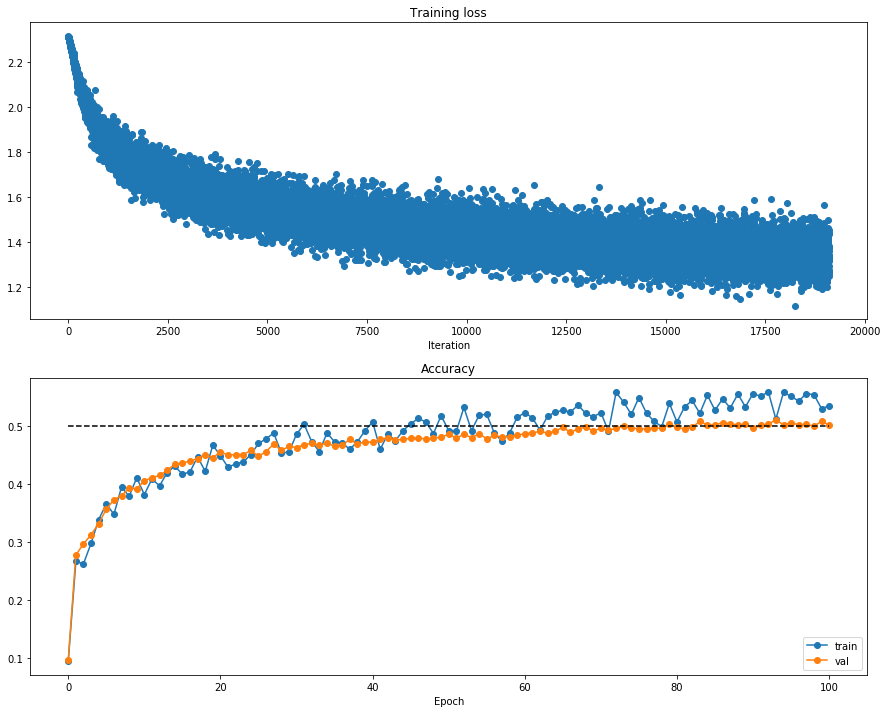

In [18]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(mysolver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(mysolver.train_acc_history, '-o', label='train')
plt.plot(mysolver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(mysolver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [57]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
dict_keys(['b2', 'W2', 'W1', 'W3', 'b1', 'b3'])
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11
Running check with reg =  3.14
dict_keys(['b2', 'W2', 'W1', 'W3', 'b1', 'b3'])
Initial loss:  7.052114776533016
W1 relative error: 7.36e-09
W2 relative error: 6.87e-08
W3 relative error: 3.48e-08
b1 relative error: 1.48e-08
b2 relative error: 1.72e-09
b3 relative error: 1.80e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

dict_keys(['b2', 'W2', 'W1', 'W3', 'b1', 'b3'])
(Iteration 1 / 40) loss: 5.921844
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.128000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.095000
(Epoch 2 / 20) train acc: 0.500000; val_acc: 0.117000
(Epoch 3 / 20) train acc: 0.660000; val_acc: 0.141000
(Epoch 4 / 20) train acc: 0.880000; val_acc: 0.208000
(Epoch 5 / 20) train acc: 0.880000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.347754
(Epoch 6 / 20) train acc: 0.880000; val_acc: 0.205000
(Epoch 7 / 20) train acc: 0.920000; val_acc: 0.198000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.203000
(Epoch 9 / 20) train acc: 1.000000; val_acc: 0.207000
(Epoch 10 / 20) train acc: 1.000000; val_acc: 0.198000
(Iteration 21 / 40) loss: 0.065495
(Epoch 11 / 20) train acc: 1.000000; val_acc: 0.200000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.205000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.206000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.0000

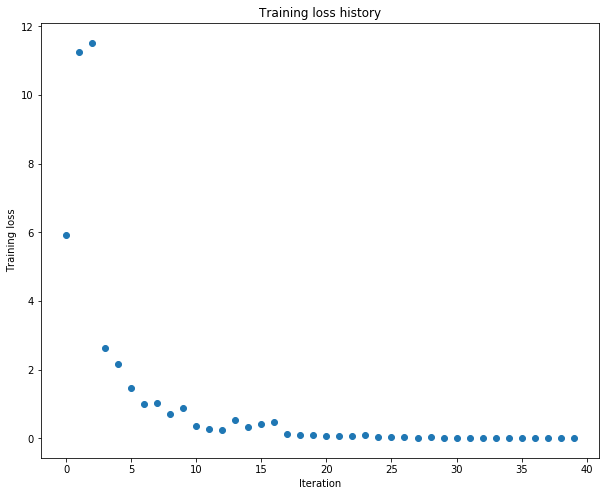

In [58]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

# (zy) use initialization from He et al., 2015
# 1/np.sqrt(input_dim/2) * standard normal
# Initialize bias to zero.
# In RNN, we can initialize B to be a large number. 
weight_scale = 2.5e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

dict_keys(['b5', 'b2', 'W4', 'W2', 'W1', 'W5', 'W3', 'b1', 'b4', 'b3'])
(Iteration 1 / 40) loss: 2.839886
(Epoch 0 / 20) train acc: 0.200000; val_acc: 0.098000
(Epoch 1 / 20) train acc: 0.200000; val_acc: 0.091000
(Epoch 2 / 20) train acc: 0.340000; val_acc: 0.102000
(Epoch 3 / 20) train acc: 0.380000; val_acc: 0.138000
(Epoch 4 / 20) train acc: 0.660000; val_acc: 0.147000
(Epoch 5 / 20) train acc: 0.600000; val_acc: 0.132000
(Iteration 11 / 40) loss: 1.070906
(Epoch 6 / 20) train acc: 0.780000; val_acc: 0.168000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.153000
(Epoch 8 / 20) train acc: 0.940000; val_acc: 0.154000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.168000
(Epoch 10 / 20) train acc: 0.900000; val_acc: 0.179000
(Iteration 21 / 40) loss: 0.367856
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.155000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.177000
(Epoch 13 / 20) train acc: 0.960000; val_acc: 0.176000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.161000
(Epoch 15

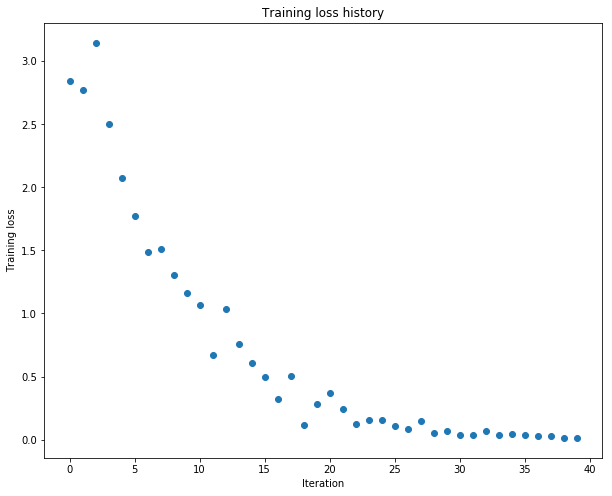

In [59]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 3e-2
weight_scale = 4e-2
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
Training the five-layer net is more difficult, as the five-layer net is more complex and its landscape is far more rough. As a result, it will be much easier to overshoot the local minima, and get loss increased, and the parameters have a smaller range of good tunning.

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [60]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.882347033505819e-09
velocity error:  4.269287743278663e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
dict_keys(['W4', 'b4', 'b3', 'W5', 'W3', 'b1', 'b6', 'b5', 'b2', 'W2', 'W1', 'W6'])
(Iteration 1 / 200) loss: 2.559978
(Epoch 0 / 5) train acc: 0.103000; val_acc: 0.108000
(Iteration 11 / 200) loss: 2.291086
(Iteration 21 / 200) loss: 2.153591
(Iteration 31 / 200) loss: 2.082693
(Epoch 1 / 5) train acc: 0.277000; val_acc: 0.242000
(Iteration 41 / 200) loss: 2.004171
(Iteration 51 / 200) loss: 2.010409
(Iteration 61 / 200) loss: 2.023753
(Iteration 71 / 200) loss: 2.026621
(Epoch 2 / 5) train acc: 0.352000; val_acc: 0.312000
(Iteration 81 / 200) loss: 1.807163
(Iteration 91 / 200) loss: 1.914256
(Iteration 101 / 200) loss: 1.920494
(Iteration 111 / 200) loss: 1.708877
(Epoch 3 / 5) train acc: 0.399000; val_acc: 0.316000
(Iteration 121 / 200) loss: 1.701111
(Iteration 131 / 200) loss: 1.769697
(Iteration 141 / 200) loss: 1.788899
(Iteration 151 / 200) loss: 1.815921
(Epoch 4 / 5) train acc: 0.430000; val_acc: 0.320000
(Iteration 161 / 200) loss: 1.631982
(Iteration 171 

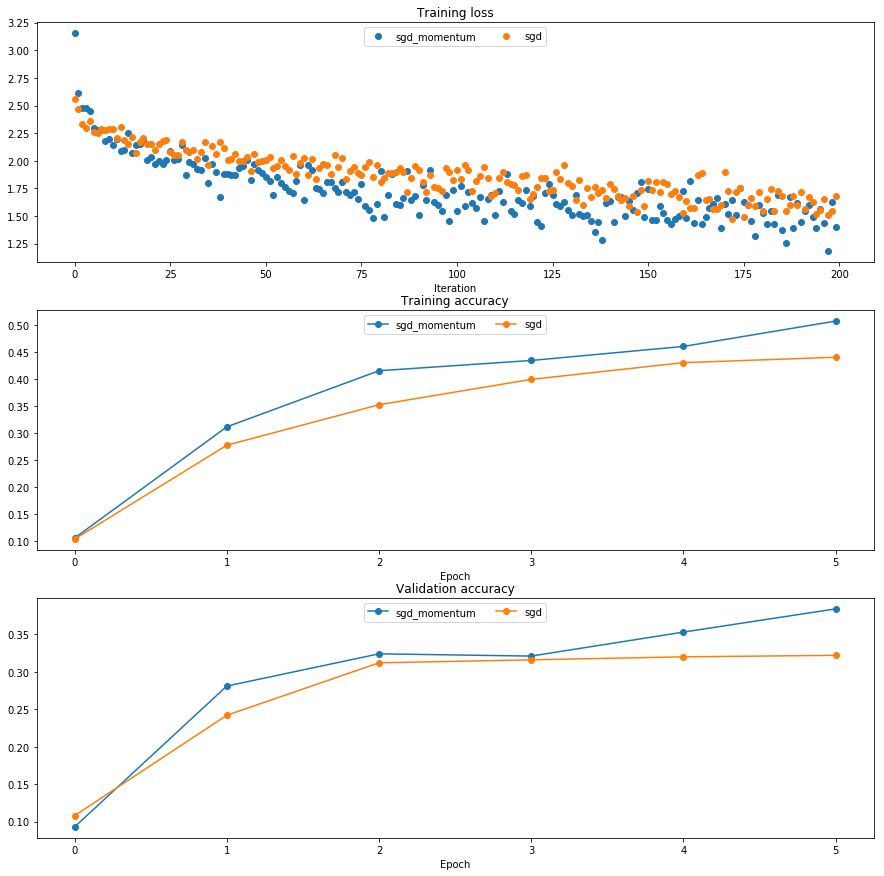

In [61]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [62]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.524687511038133e-08
cache error:  2.6477955807156126e-09


In [63]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.1395691798535431e-07
v error:  4.208314038113071e-09
m error:  4.214963193114416e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
dict_keys(['W4', 'b4', 'b3', 'W5', 'W3', 'b1', 'b6', 'b5', 'b2', 'W2', 'W1', 'W6'])
(Iteration 1 / 200) loss: 3.476928
(Epoch 0 / 5) train acc: 0.143000; val_acc: 0.114000
(Iteration 11 / 200) loss: 2.089203
(Iteration 21 / 200) loss: 2.211850
(Iteration 31 / 200) loss: 1.786014
(Epoch 1 / 5) train acc: 0.393000; val_acc: 0.340000
(Iteration 41 / 200) loss: 1.743813
(Iteration 51 / 200) loss: 1.752165
(Iteration 61 / 200) loss: 2.095686
(Iteration 71 / 200) loss: 1.489003
(Epoch 2 / 5) train acc: 0.411000; val_acc: 0.357000
(Iteration 81 / 200) loss: 1.546641
(Iteration 91 / 200) loss: 1.412223
(Iteration 101 / 200) loss: 1.401821
(Iteration 111 / 200) loss: 1.518780
(Epoch 3 / 5) train acc: 0.483000; val_acc: 0.381000
(Iteration 121 / 200) loss: 1.234374
(Iteration 131 / 200) loss: 1.452270
(Iteration 141 / 200) loss: 1.366984
(Iteration 151 / 200) loss: 1.500379
(Epoch 4 / 5) train acc: 0.542000; val_acc: 0.395000
(Iteration 161 / 200) loss: 1.335077
(Iteration 171

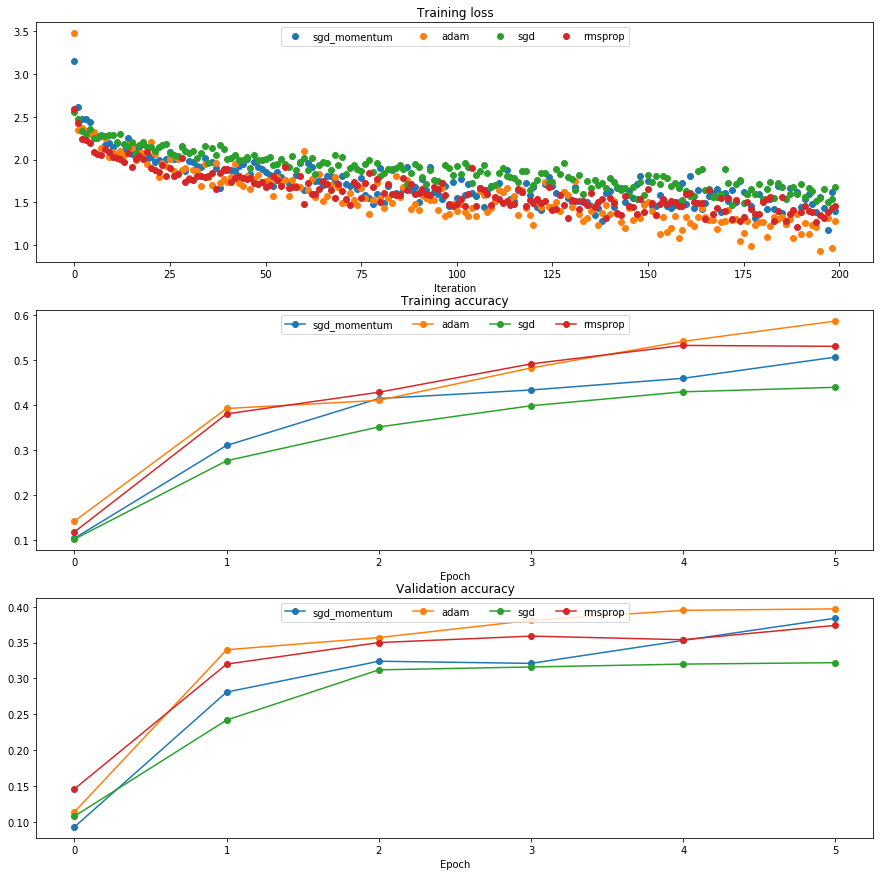

In [64]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [104]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
hidden_dims = [256, 128, 64, 32]
dropout = 0.4
reg = 0.02
wd = 8e-2
kwargs = {"update_rule": "adam", "optim_config":{"learning_rate":6e-5}, 
          "batch_size":128, "num_epochs":100}

mynet = FullyConnectedNet(hidden_dims, dropout=dropout, use_batchnorm=True,
                          reg=reg, weight_scale=wd)
mySolver = Solver(mynet, data, **kwargs)
mySolver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

dict_keys(['beta1', 'W4', 'b4', 'beta2', 'gamma2', 'W5', 'W3', 'b1', 'beta4', 'b5', 'b2', 'W2', 'W1', 'gamma4', 'gamma1', 'b3', 'beta3', 'gamma3'])
(Iteration 1 / 38200) loss: 55.623612
(Epoch 0 / 100) train acc: 0.100000; val_acc: 0.096000
(Iteration 11 / 38200) loss: 55.086159
(Iteration 21 / 38200) loss: 54.740347
(Iteration 31 / 38200) loss: 54.150465
(Iteration 41 / 38200) loss: 53.633679
(Iteration 51 / 38200) loss: 53.105777
(Iteration 61 / 38200) loss: 52.582768
(Iteration 71 / 38200) loss: 52.100065
(Iteration 81 / 38200) loss: 51.625299
(Iteration 91 / 38200) loss: 51.202292
(Iteration 101 / 38200) loss: 50.740769
(Iteration 111 / 38200) loss: 50.337731
(Iteration 121 / 38200) loss: 49.807011
(Iteration 131 / 38200) loss: 49.317895
(Iteration 141 / 38200) loss: 48.976258
(Iteration 151 / 38200) loss: 48.506916
(Iteration 161 / 38200) loss: 48.088324
(Iteration 171 / 38200) loss: 47.671874
(Iteration 181 / 38200) loss: 47.160723
(Iteration 191 / 38200) loss: 46.696318
(Iterati

(Iteration 1921 / 38200) loss: 10.066285
(Iteration 1931 / 38200) loss: 10.018781
(Iteration 1941 / 38200) loss: 9.986219
(Iteration 1951 / 38200) loss: 9.903945
(Iteration 1961 / 38200) loss: 9.799705
(Iteration 1971 / 38200) loss: 9.749855
(Iteration 1981 / 38200) loss: 9.701361
(Iteration 1991 / 38200) loss: 9.576072
(Iteration 2001 / 38200) loss: 9.421887
(Iteration 2011 / 38200) loss: 9.312179
(Iteration 2021 / 38200) loss: 9.380818
(Iteration 2031 / 38200) loss: 9.335016
(Iteration 2041 / 38200) loss: 9.181388
(Iteration 2051 / 38200) loss: 9.101019
(Iteration 2061 / 38200) loss: 9.066871
(Iteration 2071 / 38200) loss: 8.912016
(Iteration 2081 / 38200) loss: 8.833986
(Iteration 2091 / 38200) loss: 8.900324
(Iteration 2101 / 38200) loss: 8.851715
(Iteration 2111 / 38200) loss: 8.755882
(Iteration 2121 / 38200) loss: 8.586491
(Iteration 2131 / 38200) loss: 8.584373
(Iteration 2141 / 38200) loss: 8.432921
(Iteration 2151 / 38200) loss: 8.470434
(Iteration 2161 / 38200) loss: 8.39822

(Iteration 3901 / 38200) loss: 3.267904
(Iteration 3911 / 38200) loss: 3.172262
(Iteration 3921 / 38200) loss: 3.093459
(Iteration 3931 / 38200) loss: 3.177985
(Iteration 3941 / 38200) loss: 3.211980
(Iteration 3951 / 38200) loss: 3.217156
(Iteration 3961 / 38200) loss: 3.318511
(Iteration 3971 / 38200) loss: 3.159308
(Iteration 3981 / 38200) loss: 3.157243
(Iteration 3991 / 38200) loss: 3.074835
(Iteration 4001 / 38200) loss: 3.295482
(Iteration 4011 / 38200) loss: 3.031522
(Iteration 4021 / 38200) loss: 2.906465
(Iteration 4031 / 38200) loss: 3.213772
(Iteration 4041 / 38200) loss: 3.128264
(Iteration 4051 / 38200) loss: 3.035603
(Iteration 4061 / 38200) loss: 3.080947
(Iteration 4071 / 38200) loss: 3.207783
(Iteration 4081 / 38200) loss: 3.034218
(Iteration 4091 / 38200) loss: 3.177631
(Iteration 4101 / 38200) loss: 3.067493
(Iteration 4111 / 38200) loss: 3.078234
(Iteration 4121 / 38200) loss: 3.063352
(Iteration 4131 / 38200) loss: 2.973579
(Iteration 4141 / 38200) loss: 2.832749


(Iteration 5881 / 38200) loss: 2.303420
(Iteration 5891 / 38200) loss: 2.307158
(Iteration 5901 / 38200) loss: 2.157274
(Iteration 5911 / 38200) loss: 2.245217
(Iteration 5921 / 38200) loss: 2.251362
(Iteration 5931 / 38200) loss: 2.280784
(Iteration 5941 / 38200) loss: 2.151366
(Iteration 5951 / 38200) loss: 2.151802
(Iteration 5961 / 38200) loss: 2.277989
(Iteration 5971 / 38200) loss: 2.097239
(Iteration 5981 / 38200) loss: 2.157846
(Iteration 5991 / 38200) loss: 2.160543
(Iteration 6001 / 38200) loss: 2.222241
(Iteration 6011 / 38200) loss: 2.284948
(Iteration 6021 / 38200) loss: 2.210492
(Iteration 6031 / 38200) loss: 2.196887
(Iteration 6041 / 38200) loss: 2.152697
(Iteration 6051 / 38200) loss: 2.182096
(Iteration 6061 / 38200) loss: 2.208790
(Iteration 6071 / 38200) loss: 2.072814
(Iteration 6081 / 38200) loss: 2.209410
(Iteration 6091 / 38200) loss: 2.120516
(Iteration 6101 / 38200) loss: 2.057261
(Iteration 6111 / 38200) loss: 2.159917
(Epoch 16 / 100) train acc: 0.322000; va

(Iteration 7861 / 38200) loss: 1.911383
(Iteration 7871 / 38200) loss: 2.021198
(Iteration 7881 / 38200) loss: 2.052114
(Iteration 7891 / 38200) loss: 2.111826
(Iteration 7901 / 38200) loss: 2.057269
(Iteration 7911 / 38200) loss: 1.883370
(Iteration 7921 / 38200) loss: 1.874583
(Iteration 7931 / 38200) loss: 1.986668
(Iteration 7941 / 38200) loss: 1.873833
(Iteration 7951 / 38200) loss: 1.931304
(Iteration 7961 / 38200) loss: 1.829619
(Iteration 7971 / 38200) loss: 1.829024
(Iteration 7981 / 38200) loss: 1.828705
(Iteration 7991 / 38200) loss: 1.868016
(Iteration 8001 / 38200) loss: 1.815393
(Iteration 8011 / 38200) loss: 2.046402
(Iteration 8021 / 38200) loss: 1.989334
(Epoch 21 / 100) train acc: 0.353000; val_acc: 0.376000
(Iteration 8031 / 38200) loss: 1.901475
(Iteration 8041 / 38200) loss: 1.918897
(Iteration 8051 / 38200) loss: 1.741213
(Iteration 8061 / 38200) loss: 1.991213
(Iteration 8071 / 38200) loss: 1.959445
(Iteration 8081 / 38200) loss: 2.017799
(Iteration 8091 / 38200)

(Iteration 9841 / 38200) loss: 1.819228
(Iteration 9851 / 38200) loss: 1.791594
(Iteration 9861 / 38200) loss: 1.814790
(Iteration 9871 / 38200) loss: 1.782284
(Iteration 9881 / 38200) loss: 1.958209
(Iteration 9891 / 38200) loss: 1.942421
(Iteration 9901 / 38200) loss: 1.861217
(Iteration 9911 / 38200) loss: 1.832867
(Iteration 9921 / 38200) loss: 1.856738
(Iteration 9931 / 38200) loss: 1.819503
(Epoch 26 / 100) train acc: 0.416000; val_acc: 0.406000
(Iteration 9941 / 38200) loss: 1.920259
(Iteration 9951 / 38200) loss: 1.723645
(Iteration 9961 / 38200) loss: 1.755397
(Iteration 9971 / 38200) loss: 1.753077
(Iteration 9981 / 38200) loss: 1.853963
(Iteration 9991 / 38200) loss: 1.922252
(Iteration 10001 / 38200) loss: 1.804096
(Iteration 10011 / 38200) loss: 1.711255
(Iteration 10021 / 38200) loss: 1.763867
(Iteration 10031 / 38200) loss: 1.778743
(Iteration 10041 / 38200) loss: 1.737802
(Iteration 10051 / 38200) loss: 1.759159
(Iteration 10061 / 38200) loss: 1.875861
(Iteration 10071 

(Iteration 11781 / 38200) loss: 1.778130
(Iteration 11791 / 38200) loss: 1.803669
(Iteration 11801 / 38200) loss: 1.742515
(Iteration 11811 / 38200) loss: 1.728418
(Iteration 11821 / 38200) loss: 1.787789
(Iteration 11831 / 38200) loss: 1.890587
(Iteration 11841 / 38200) loss: 1.680273
(Epoch 31 / 100) train acc: 0.424000; val_acc: 0.425000
(Iteration 11851 / 38200) loss: 1.725754
(Iteration 11861 / 38200) loss: 1.812130
(Iteration 11871 / 38200) loss: 1.769319
(Iteration 11881 / 38200) loss: 1.671883
(Iteration 11891 / 38200) loss: 1.619080
(Iteration 11901 / 38200) loss: 1.704114
(Iteration 11911 / 38200) loss: 1.679543
(Iteration 11921 / 38200) loss: 1.700890
(Iteration 11931 / 38200) loss: 1.680044
(Iteration 11941 / 38200) loss: 1.670217
(Iteration 11951 / 38200) loss: 1.806804
(Iteration 11961 / 38200) loss: 1.771028
(Iteration 11971 / 38200) loss: 1.735245
(Iteration 11981 / 38200) loss: 1.826384
(Iteration 11991 / 38200) loss: 1.843970
(Iteration 12001 / 38200) loss: 1.766398
(

(Iteration 13711 / 38200) loss: 1.541883
(Iteration 13721 / 38200) loss: 1.732447
(Iteration 13731 / 38200) loss: 1.684157
(Iteration 13741 / 38200) loss: 1.960066
(Iteration 13751 / 38200) loss: 1.675394
(Epoch 36 / 100) train acc: 0.469000; val_acc: 0.452000
(Iteration 13761 / 38200) loss: 1.551082
(Iteration 13771 / 38200) loss: 1.709350
(Iteration 13781 / 38200) loss: 1.660371
(Iteration 13791 / 38200) loss: 1.744664
(Iteration 13801 / 38200) loss: 1.609537
(Iteration 13811 / 38200) loss: 1.635591
(Iteration 13821 / 38200) loss: 1.682689
(Iteration 13831 / 38200) loss: 1.772219
(Iteration 13841 / 38200) loss: 1.866488
(Iteration 13851 / 38200) loss: 1.753386
(Iteration 13861 / 38200) loss: 1.846504
(Iteration 13871 / 38200) loss: 1.648645
(Iteration 13881 / 38200) loss: 1.699944
(Iteration 13891 / 38200) loss: 1.768360
(Iteration 13901 / 38200) loss: 1.655888
(Iteration 13911 / 38200) loss: 1.822676
(Iteration 13921 / 38200) loss: 1.704470
(Iteration 13931 / 38200) loss: 1.752795
(

(Iteration 15641 / 38200) loss: 1.777280
(Iteration 15651 / 38200) loss: 1.724301
(Iteration 15661 / 38200) loss: 1.704848
(Epoch 41 / 100) train acc: 0.464000; val_acc: 0.446000
(Iteration 15671 / 38200) loss: 1.762055
(Iteration 15681 / 38200) loss: 1.721539
(Iteration 15691 / 38200) loss: 1.708969
(Iteration 15701 / 38200) loss: 1.617032
(Iteration 15711 / 38200) loss: 1.687780
(Iteration 15721 / 38200) loss: 1.562298
(Iteration 15731 / 38200) loss: 1.656407
(Iteration 15741 / 38200) loss: 1.545178
(Iteration 15751 / 38200) loss: 1.790475
(Iteration 15761 / 38200) loss: 1.800412
(Iteration 15771 / 38200) loss: 1.540823
(Iteration 15781 / 38200) loss: 1.737092
(Iteration 15791 / 38200) loss: 1.868937
(Iteration 15801 / 38200) loss: 1.584506
(Iteration 15811 / 38200) loss: 1.678620
(Iteration 15821 / 38200) loss: 1.520749
(Iteration 15831 / 38200) loss: 1.532689
(Iteration 15841 / 38200) loss: 1.699398
(Iteration 15851 / 38200) loss: 1.643661
(Iteration 15861 / 38200) loss: 1.823953
(

(Iteration 17571 / 38200) loss: 1.800979
(Epoch 46 / 100) train acc: 0.486000; val_acc: 0.464000
(Iteration 17581 / 38200) loss: 1.572802
(Iteration 17591 / 38200) loss: 1.636268
(Iteration 17601 / 38200) loss: 1.648491
(Iteration 17611 / 38200) loss: 1.781165
(Iteration 17621 / 38200) loss: 1.666757
(Iteration 17631 / 38200) loss: 1.645412
(Iteration 17641 / 38200) loss: 1.548986
(Iteration 17651 / 38200) loss: 1.613273
(Iteration 17661 / 38200) loss: 1.588647
(Iteration 17671 / 38200) loss: 1.636818
(Iteration 17681 / 38200) loss: 1.806507
(Iteration 17691 / 38200) loss: 1.814548
(Iteration 17701 / 38200) loss: 1.663725
(Iteration 17711 / 38200) loss: 1.567102
(Iteration 17721 / 38200) loss: 1.705477
(Iteration 17731 / 38200) loss: 1.687731
(Iteration 17741 / 38200) loss: 1.649801
(Iteration 17751 / 38200) loss: 1.557476
(Iteration 17761 / 38200) loss: 1.638843
(Iteration 17771 / 38200) loss: 1.818144
(Iteration 17781 / 38200) loss: 1.615221
(Iteration 17791 / 38200) loss: 1.641774
(

(Iteration 19491 / 38200) loss: 1.605876
(Iteration 19501 / 38200) loss: 1.569274
(Iteration 19511 / 38200) loss: 1.807934
(Iteration 19521 / 38200) loss: 1.571025
(Iteration 19531 / 38200) loss: 1.715851
(Iteration 19541 / 38200) loss: 1.707348
(Iteration 19551 / 38200) loss: 1.725100
(Iteration 19561 / 38200) loss: 1.726036
(Iteration 19571 / 38200) loss: 1.606691
(Iteration 19581 / 38200) loss: 1.698333
(Iteration 19591 / 38200) loss: 1.544668
(Iteration 19601 / 38200) loss: 1.642164
(Iteration 19611 / 38200) loss: 1.558456
(Iteration 19621 / 38200) loss: 1.727233
(Iteration 19631 / 38200) loss: 1.476443
(Iteration 19641 / 38200) loss: 1.608374
(Iteration 19651 / 38200) loss: 1.595910
(Iteration 19661 / 38200) loss: 1.486754
(Iteration 19671 / 38200) loss: 1.586568
(Iteration 19681 / 38200) loss: 1.549109
(Iteration 19691 / 38200) loss: 1.567724
(Iteration 19701 / 38200) loss: 1.682168
(Iteration 19711 / 38200) loss: 1.648096
(Iteration 19721 / 38200) loss: 1.484275
(Iteration 19731

(Iteration 21421 / 38200) loss: 1.643807
(Iteration 21431 / 38200) loss: 1.582089
(Iteration 21441 / 38200) loss: 1.717616
(Iteration 21451 / 38200) loss: 1.579442
(Iteration 21461 / 38200) loss: 1.674741
(Iteration 21471 / 38200) loss: 1.656721
(Iteration 21481 / 38200) loss: 1.739547
(Iteration 21491 / 38200) loss: 1.511707
(Iteration 21501 / 38200) loss: 1.590879
(Iteration 21511 / 38200) loss: 1.579379
(Iteration 21521 / 38200) loss: 1.569264
(Iteration 21531 / 38200) loss: 1.513236
(Iteration 21541 / 38200) loss: 1.686347
(Iteration 21551 / 38200) loss: 1.551625
(Iteration 21561 / 38200) loss: 1.588126
(Iteration 21571 / 38200) loss: 1.598411
(Iteration 21581 / 38200) loss: 1.461473
(Iteration 21591 / 38200) loss: 1.577109
(Iteration 21601 / 38200) loss: 1.746040
(Iteration 21611 / 38200) loss: 1.629685
(Iteration 21621 / 38200) loss: 1.693379
(Iteration 21631 / 38200) loss: 1.810831
(Iteration 21641 / 38200) loss: 1.641923
(Iteration 21651 / 38200) loss: 1.610050
(Iteration 21661

(Iteration 23351 / 38200) loss: 1.622365
(Iteration 23361 / 38200) loss: 1.487946
(Iteration 23371 / 38200) loss: 1.491661
(Iteration 23381 / 38200) loss: 1.683809
(Iteration 23391 / 38200) loss: 1.732559
(Iteration 23401 / 38200) loss: 1.623366
(Iteration 23411 / 38200) loss: 1.691454
(Iteration 23421 / 38200) loss: 1.598625
(Iteration 23431 / 38200) loss: 1.751414
(Iteration 23441 / 38200) loss: 1.446980
(Iteration 23451 / 38200) loss: 1.539878
(Iteration 23461 / 38200) loss: 1.455902
(Iteration 23471 / 38200) loss: 1.626442
(Iteration 23481 / 38200) loss: 1.657499
(Iteration 23491 / 38200) loss: 1.702748
(Iteration 23501 / 38200) loss: 1.707168
(Iteration 23511 / 38200) loss: 1.460967
(Iteration 23521 / 38200) loss: 1.842191
(Iteration 23531 / 38200) loss: 1.626520
(Iteration 23541 / 38200) loss: 1.626380
(Iteration 23551 / 38200) loss: 1.597483
(Iteration 23561 / 38200) loss: 1.556877
(Iteration 23571 / 38200) loss: 1.671982
(Iteration 23581 / 38200) loss: 1.695390
(Iteration 23591

(Iteration 25281 / 38200) loss: 1.572420
(Iteration 25291 / 38200) loss: 1.575283
(Iteration 25301 / 38200) loss: 1.429905
(Iteration 25311 / 38200) loss: 1.536725
(Iteration 25321 / 38200) loss: 1.622051
(Iteration 25331 / 38200) loss: 1.660665
(Iteration 25341 / 38200) loss: 1.587901
(Iteration 25351 / 38200) loss: 1.507686
(Iteration 25361 / 38200) loss: 1.633915
(Iteration 25371 / 38200) loss: 1.726624
(Iteration 25381 / 38200) loss: 1.734402
(Iteration 25391 / 38200) loss: 1.748340
(Iteration 25401 / 38200) loss: 1.699436
(Iteration 25411 / 38200) loss: 1.634297
(Iteration 25421 / 38200) loss: 1.562484
(Iteration 25431 / 38200) loss: 1.527877
(Iteration 25441 / 38200) loss: 1.599770
(Iteration 25451 / 38200) loss: 1.558280
(Iteration 25461 / 38200) loss: 1.559593
(Iteration 25471 / 38200) loss: 1.572134
(Iteration 25481 / 38200) loss: 1.635952
(Iteration 25491 / 38200) loss: 1.594600
(Iteration 25501 / 38200) loss: 1.544449
(Iteration 25511 / 38200) loss: 1.892668
(Iteration 25521

(Iteration 27211 / 38200) loss: 1.556487
(Iteration 27221 / 38200) loss: 1.571532
(Iteration 27231 / 38200) loss: 1.648275
(Iteration 27241 / 38200) loss: 1.449455
(Iteration 27251 / 38200) loss: 1.632664
(Iteration 27261 / 38200) loss: 1.642261
(Iteration 27271 / 38200) loss: 1.555781
(Iteration 27281 / 38200) loss: 1.558551
(Iteration 27291 / 38200) loss: 1.483092
(Iteration 27301 / 38200) loss: 1.540985
(Iteration 27311 / 38200) loss: 1.622142
(Iteration 27321 / 38200) loss: 1.653616
(Iteration 27331 / 38200) loss: 1.550281
(Iteration 27341 / 38200) loss: 1.525282
(Iteration 27351 / 38200) loss: 1.677745
(Iteration 27361 / 38200) loss: 1.511052
(Iteration 27371 / 38200) loss: 1.605350
(Iteration 27381 / 38200) loss: 1.504069
(Iteration 27391 / 38200) loss: 1.570820
(Iteration 27401 / 38200) loss: 1.555322
(Iteration 27411 / 38200) loss: 1.644019
(Iteration 27421 / 38200) loss: 1.707996
(Iteration 27431 / 38200) loss: 1.545266
(Iteration 27441 / 38200) loss: 1.479135
(Iteration 27451

(Iteration 29141 / 38200) loss: 1.463557
(Iteration 29151 / 38200) loss: 1.541927
(Iteration 29161 / 38200) loss: 1.749498
(Iteration 29171 / 38200) loss: 1.522804
(Iteration 29181 / 38200) loss: 1.717139
(Iteration 29191 / 38200) loss: 1.520685
(Iteration 29201 / 38200) loss: 1.571607
(Iteration 29211 / 38200) loss: 1.529415
(Iteration 29221 / 38200) loss: 1.561788
(Iteration 29231 / 38200) loss: 1.466089
(Iteration 29241 / 38200) loss: 1.699643
(Iteration 29251 / 38200) loss: 1.677245
(Iteration 29261 / 38200) loss: 1.534355
(Iteration 29271 / 38200) loss: 1.497205
(Iteration 29281 / 38200) loss: 1.441231
(Iteration 29291 / 38200) loss: 1.659119
(Iteration 29301 / 38200) loss: 1.663374
(Iteration 29311 / 38200) loss: 1.591294
(Iteration 29321 / 38200) loss: 1.544875
(Iteration 29331 / 38200) loss: 1.440215
(Iteration 29341 / 38200) loss: 1.609550
(Iteration 29351 / 38200) loss: 1.561329
(Iteration 29361 / 38200) loss: 1.527676
(Iteration 29371 / 38200) loss: 1.583322
(Iteration 29381

(Iteration 31071 / 38200) loss: 1.548623
(Iteration 31081 / 38200) loss: 1.560793
(Iteration 31091 / 38200) loss: 1.646705
(Iteration 31101 / 38200) loss: 1.627108
(Iteration 31111 / 38200) loss: 1.682885
(Iteration 31121 / 38200) loss: 1.417616
(Iteration 31131 / 38200) loss: 1.546745
(Iteration 31141 / 38200) loss: 1.813669
(Iteration 31151 / 38200) loss: 1.678760
(Iteration 31161 / 38200) loss: 1.459647
(Iteration 31171 / 38200) loss: 1.667363
(Iteration 31181 / 38200) loss: 1.617940
(Iteration 31191 / 38200) loss: 1.417633
(Iteration 31201 / 38200) loss: 1.537746
(Iteration 31211 / 38200) loss: 1.770883
(Iteration 31221 / 38200) loss: 1.520116
(Iteration 31231 / 38200) loss: 1.691035
(Iteration 31241 / 38200) loss: 1.487062
(Iteration 31251 / 38200) loss: 1.503081
(Iteration 31261 / 38200) loss: 1.653920
(Iteration 31271 / 38200) loss: 1.724694
(Iteration 31281 / 38200) loss: 1.563657
(Iteration 31291 / 38200) loss: 1.640768
(Iteration 31301 / 38200) loss: 1.669718
(Iteration 31311

(Iteration 33001 / 38200) loss: 1.513024
(Iteration 33011 / 38200) loss: 1.496310
(Iteration 33021 / 38200) loss: 1.529394
(Iteration 33031 / 38200) loss: 1.742270
(Iteration 33041 / 38200) loss: 1.591596
(Iteration 33051 / 38200) loss: 1.563001
(Iteration 33061 / 38200) loss: 1.749200
(Iteration 33071 / 38200) loss: 1.582724
(Iteration 33081 / 38200) loss: 1.612621
(Iteration 33091 / 38200) loss: 1.657763
(Iteration 33101 / 38200) loss: 1.954195
(Iteration 33111 / 38200) loss: 1.516275
(Iteration 33121 / 38200) loss: 1.500093
(Iteration 33131 / 38200) loss: 1.695374
(Iteration 33141 / 38200) loss: 1.642609
(Iteration 33151 / 38200) loss: 1.497110
(Iteration 33161 / 38200) loss: 1.795311
(Iteration 33171 / 38200) loss: 1.574061
(Iteration 33181 / 38200) loss: 1.541881
(Iteration 33191 / 38200) loss: 1.565116
(Iteration 33201 / 38200) loss: 1.774152
(Iteration 33211 / 38200) loss: 1.627071
(Iteration 33221 / 38200) loss: 1.676177
(Iteration 33231 / 38200) loss: 1.674939
(Epoch 87 / 100)

(Iteration 34931 / 38200) loss: 1.525804
(Iteration 34941 / 38200) loss: 1.486523
(Iteration 34951 / 38200) loss: 1.424840
(Iteration 34961 / 38200) loss: 1.595996
(Iteration 34971 / 38200) loss: 1.593979
(Iteration 34981 / 38200) loss: 1.474598
(Iteration 34991 / 38200) loss: 1.564023
(Iteration 35001 / 38200) loss: 1.601576
(Iteration 35011 / 38200) loss: 1.484482
(Iteration 35021 / 38200) loss: 1.756277
(Iteration 35031 / 38200) loss: 1.638352
(Iteration 35041 / 38200) loss: 1.485394
(Iteration 35051 / 38200) loss: 1.616129
(Iteration 35061 / 38200) loss: 1.549091
(Iteration 35071 / 38200) loss: 1.473149
(Iteration 35081 / 38200) loss: 1.530666
(Iteration 35091 / 38200) loss: 1.463591
(Iteration 35101 / 38200) loss: 1.585046
(Iteration 35111 / 38200) loss: 1.667171
(Iteration 35121 / 38200) loss: 1.837345
(Iteration 35131 / 38200) loss: 1.461182
(Iteration 35141 / 38200) loss: 1.641001
(Epoch 92 / 100) train acc: 0.569000; val_acc: 0.511000
(Iteration 35151 / 38200) loss: 1.471847
(

(Iteration 36861 / 38200) loss: 1.688805
(Iteration 36871 / 38200) loss: 1.550741
(Iteration 36881 / 38200) loss: 1.678399
(Iteration 36891 / 38200) loss: 1.555944
(Iteration 36901 / 38200) loss: 1.351674
(Iteration 36911 / 38200) loss: 1.624879
(Iteration 36921 / 38200) loss: 1.628003
(Iteration 36931 / 38200) loss: 1.669521
(Iteration 36941 / 38200) loss: 1.545321
(Iteration 36951 / 38200) loss: 1.568775
(Iteration 36961 / 38200) loss: 1.551056
(Iteration 36971 / 38200) loss: 1.504214
(Iteration 36981 / 38200) loss: 1.798854
(Iteration 36991 / 38200) loss: 1.588429
(Iteration 37001 / 38200) loss: 1.513500
(Iteration 37011 / 38200) loss: 1.423967
(Iteration 37021 / 38200) loss: 1.543990
(Iteration 37031 / 38200) loss: 1.677008
(Iteration 37041 / 38200) loss: 1.601610
(Iteration 37051 / 38200) loss: 1.641615
(Epoch 97 / 100) train acc: 0.563000; val_acc: 0.498000
(Iteration 37061 / 38200) loss: 1.562246
(Iteration 37071 / 38200) loss: 1.632901
(Iteration 37081 / 38200) loss: 1.566809
(

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [106]:
best_model=mynet
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.52
Test set accuracy:  0.531
